In [64]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import linspace
import pandas as pd 
import seaborn as sns 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import linear_model, preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, \
    confusion_matrix, mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.graphics.api import abline_plot

In [2]:
df = pd.read_csv('data/03_eda_loans50k.csv', index_col=[0])

In [3]:
df.head()

,amount,term,length,home,income,verified,status,reason,state,debtIncRat,...,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
loanID,,,,,,,,,,,,,,,,,,,,,
188861,8000.0,36 months,3 years,RENT,49966.0,Verified,Default,credit_card,Quartile_3,30.05,...,15.0,48054.0,8100.0,8.0,4369.0,43.0,95.7,48054.0,1000.0,52529.0
517703,11000.0,36 months,10+ years,MORTGAGE,50000.0,Not Verified,Current,debt_consolidation,Quartile_3,8.74,...,15.0,265838.0,33400.0,4.0,22153.0,19756.0,37.5,11844.0,31600.0,0.0
268587,35000.0,36 months,10+ years,RENT,360000.0,Verified,Current,debt_consolidation,Quartile_3,14.50,...,14.0,850150.0,83000.0,2.0,121450.0,7686.0,83.2,173260.0,83000.0,100000.0
579902,20000.0,60 months,2 years,MORTGAGE,60000.0,Verified,Current,debt_consolidation,Quartile_3,14.14,...,48.0,20671.0,14200.0,8.0,1723.0,11061.0,1.2,20671.0,11200.0,32764.0
617630,12000.0,60 months,10+ years,MORTGAGE,64000.0,Verified,Current,debt_consolidation,Quartile_3,5.14,...,22.0,128034.0,14600.0,3.0,18291.0,5904.0,58.4,8475.0,14200.0,0.0


**Feature Encoding using One Hot Encoding on all categorical data. This took the number of features from 25 to 49.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49184 entries, 188861 to 500393
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount       49184 non-null  float64
 1   term         49184 non-null  object 
 2   length       49184 non-null  object 
 3   home         49184 non-null  object 
 4   income       49184 non-null  float64
 5   verified     49184 non-null  object 
 6   status       49184 non-null  object 
 7   reason       49184 non-null  object 
 8   state        49184 non-null  object 
 9   debtIncRat   49184 non-null  float64
 10  delinq2yr    49184 non-null  float64
 11  inq6mth      49184 non-null  float64
 12  openAcc      49184 non-null  float64
 13  pubRec       49184 non-null  float64
 14  revolRatio   49184 non-null  float64
 15  totalAcc     49184 non-null  float64
 16  totalBal     49184 non-null  float64
 17  totalRevLim  49184 non-null  float64
 18  accOpen24    49184 non-null  float64
 19

**Before encoding, I need to map the length feature to preserve the hierarchical order of the data.**

In [5]:
# Confirm unique values to be mapped.
print(df['length'].unique())

['3 years' '10+ years' '2 years' '< 1 year' '9 years' '5 years' '1 year'
 '4 years' '8 years' '7 years' '6 years' '0 years']


In [6]:
length_map = {"0 years": 0, "< 1 year": 1, "1 year": 2, "2 years": 3, "3 years": 4,\
              "4 years": 5, "5 years": 6, "6 years": 7, "7 years": 8,\
              "8 years": 9, "9 years": 10, "10+ years": 11}
df['length'] = df['length'].map(length_map).astype(int)

In [7]:
# Check new variables
df.length.unique()

array([ 4, 11,  3,  1, 10,  6,  2,  5,  9,  8,  7,  0])

**Split data into targt variable (y) and features (X) Then use dummy encoding to transform categorical features.**

In [32]:
# Split and then get dummies
X = df.drop('status', axis=1)
y = df['status']
# Encode y
y = y.replace({'Current': 0, 'Default': 1})

In [34]:
# Create dummies and check new feautures
X = pd.get_dummies(X, drop_first=True)
X.columns

Index(['amount', 'length', 'income', 'debtIncRat', 'delinq2yr', 'inq6mth',
       'openAcc', 'pubRec', 'revolRatio', 'totalAcc', 'totalBal',
       'totalRevLim', 'accOpen24', 'avgBal', 'bcOpen', 'bcRatio',
       'totalRevBal', 'totalBcLim', 'totalIlLim', 'term_ 60 months',
       'home_OWN', 'home_RENT', 'verified_Verified', 'reason_credit_card',
       'reason_debt_consolidation', 'reason_home_improvement', 'reason_house',
       'reason_major_purchase', 'reason_medical', 'reason_moving',
       'reason_other', 'reason_renewable_energy', 'reason_small_business',
       'reason_vacation', 'reason_wedding', 'state_Quartile_2',
       'state_Quartile_3', 'state_Quartile_4'],
      dtype='object')

In [11]:
len(X.columns)

38

In [12]:
X.dtypes.value_counts()

uint8      19
float64    18
int64       1
dtype: int64

In [15]:
# Change uint8 data tpes to int
uint8_cols = X.select_dtypes(include='uint8').columns
X[uint8_cols] = X[uint8_cols].astype('int')

In [17]:
# Confirm uint8 have been changes to int64
X.dtypes.value_counts()

int64      20
float64    18
dtype: int64

**Train / Test Split & Scale using StandardScaler.**

In [35]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# initialize a StandardScaler object and fit it on the training data
scaler = StandardScaler()
scaler.fit(X_train)

# apply the scaling transformation to both the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

**I wanted to check to see if there were a similar amount of defaults in the training and test set. The ratio is close enough.**

In [37]:
# Find ratios of defaults in the training set
ratio_defaults_train = y_train.sum() / len(y_train)
# Find ratios of defaults in the test set
ratio_defaults_test = y_test.sum() / len(y_test)
print(f"The ratio of defaults in the training set is {ratio_defaults_train:.2%} and the ratio in the test set is \
{ratio_defaults_test:.2%}")

The ratio of defaults in the training set is 15.53% and the ratio in the test set is 14.95%


**Data is ready for modeling. I'm going to try 4 models and pick the top 1 or 2 models to move forward with: <br> Logistic Regression <br> Random Forest Classifier <br> Gradient Boosting Classifier <br> Decision Tree**

In [38]:
# Create a logistic regression object
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model on the training data (scaled data)
lr.fit(X_train_scaled, y_train)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
lr_acc = accuracy_score(y_test, y_pred)
lr_prec = precision_score(y_test, y_pred)
lr_rec = recall_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred)
lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", lr_acc)
print("Precision:", lr_prec)
print("Recall:", lr_rec)
print("F1 score:", lr_f1)
print("ROC-AUC score:", lr_roc_auc)

Accuracy: 0.639219274168954
Precision: 0.23855057876195268
Recall: 0.6444595513256288
F1 score: 0.34820936639118455
ROC-AUC score: 0.6413787118330272


In [40]:
# Create a random forest classifier object
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model on the training data (unscaled)
rfc.fit(X_train, y_train)

# Make predictions on the test data (unscaled)
y_pred = rfc.predict(X_test)

# Calculate the metrics
rfc_acc = accuracy_score(y_test, y_pred)
rfc_prec = precision_score(y_test, y_pred)
rfc_rec = recall_score(y_test, y_pred)
rfc_f1 = f1_score(y_test, y_pred)
rfc_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", rfc_acc)
print("Precision:", rfc_prec)
print("Recall:", rfc_rec)
print("F1 score:", rfc_f1)
print("ROC-AUC score:", rfc_roc_auc)

Accuracy: 0.8507675104198434
Precision: 0.6363636363636364
Recall: 0.004758667573079538
F1 score: 0.009446693657219974
ROC-AUC score: 0.5021402709130041


In [43]:
# Create a gradient boosting classifier object
gb = GradientBoostingClassifier(random_state=42)

# Train the model on the training data (unscaled)
gb.fit(X_train, y_train)

# Make predictions on the test data (unscaled)
y_pred = gb.predict(X_test)

# Calculate the metrics
gb_acc = accuracy_score(y_test, y_pred)
gb_prec = precision_score(y_test, y_pred)
gb_rec = recall_score(y_test, y_pred)
gb_f1 = f1_score(y_test, y_pred)
gb_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", gb_acc)
print("Precision:", gb_prec)
print("Recall:", gb_rec)
print("F1 score:", gb_f1)
print("ROC-AUC score:", gb_roc_auc)

Accuracy: 0.850462539392091
Precision: 0.5
Recall: 0.013596193065941536
F1 score: 0.026472534745201854
ROC-AUC score: 0.5056027821652921


In [52]:
# Initialize the decision tree classifier with default hyperparameters
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Train the decision tree classifier on the training set (unbalanced)
dtc.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dtc.predict(X_test)

# Calculate the metrics
dtc_acc = accuracy_score(y_test, y_pred)
dtc_prec = precision_score(y_test, y_pred)
dtc_rec = recall_score(y_test, y_pred)
dtc_f1 = f1_score(y_test, y_pred)
dtc_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", dtc_acc)
print("Precision:", dtc_prec)
print("Recall:", dtc_rec)
print("F1 score:", dtc_f1)
print("ROC-AUC score:", dtc_roc_auc)

Accuracy: 0.7550066077056014
Precision: 0.19729206963249515
Recall: 0.2080217539089055
F1 score: 0.20251489080079416
ROC-AUC score: 0.5296025575664537


In [63]:
# create a dictionary of scores for each model
scores_dict = {
    'Model': ['LR','RFC', 'GB', 'DTC'],
    'Accuracy': [lr_acc, rfc_acc, gb_acc, dtc_acc],
    'Precision': [lr_prec, rfc_prec, gb_prec, dtc_prec],
    'Recall': [lr_rec, rfc_rec, gb_rec, dtc_rec],
    'F1 Score': [lr_f1, rfc_f1, gb_f1, dtc_f1],
    'ROC-AUC Score': [lr_roc_auc, rfc_roc_auc, gb_roc_auc, dtc_roc_auc,]
}

# create the DataFrame
scores_df = pd.DataFrame(scores_dict)
scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR,0.639219,0.238551,0.644460,0.348209,0.641379
1,RFC,0.850768,0.636364,0.004759,0.009447,0.502140
2,GB,0.850463,0.500000,0.013596,0.026473,0.505603
3,DTC,0.755007,0.197292,0.208022,0.202515,0.529603


**Because we care most about detecting true loan defaults, we will move forward with logistic regression as is has the highest recall score.**

In [56]:
# create oversampled training set using synthetic data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# create oversampled training set
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_scaled, y_train)

# create undersampled training set
rus = RandomUnderSampler(random_state=42, replacement=True)
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

In [57]:
# Use synthetic oversampling

# Train the model on the training data (scaled data)
lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
sm_lr_acc = accuracy_score(y_test, y_pred)
sm_lr_prec = precision_score(y_test, y_pred)
sm_lr_rec = recall_score(y_test, y_pred)
sm_lr_f1 = f1_score(y_test, y_pred)
sm_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", sm_lr_acc)
print("Precision:", sm_lr_prec)
print("Recall:", sm_lr_rec)
print("F1 score:", sm_lr_f1)
print("ROC-AUC score:", sm_lr_roc_auc)

Accuracy: 0.6388126461319508
Precision: 0.2402694610778443
Recall: 0.6546566961250849
F1 score: 0.35152400073006024
ROC-AUC score: 0.6453417355834605


In [58]:
# Use random oversampling

# Train the model on the training data (scaled data)
lr.fit(X_train_ros, y_train_ros)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
ros_lr_acc = accuracy_score(y_test, y_pred)
ros_lr_prec = precision_score(y_test, y_pred)
ros_lr_rec = recall_score(y_test, y_pred)
ros_lr_f1 = f1_score(y_test, y_pred)
ros_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", ros_lr_acc)
print("Precision:", ros_lr_prec)
print("Recall:", ros_lr_rec)
print("F1 score:", ros_lr_f1)
print("ROC-AUC score:", ros_lr_roc_auc)

Accuracy: 0.6393209311782048
Precision: 0.23821527602722462
Recall: 0.6424201223657376
F1 score: 0.34755424788525197
ROC-AUC score: 0.6405980602266172


In [59]:
# Use random udersampling

# Train the model on the training data (scaled data)
lr.fit(X_train_rus, y_train_rus)

# Make predictions on the test data (scaled data)
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
rus_lr_acc = accuracy_score(y_test, y_pred)
rus_lr_prec = precision_score(y_test, y_pred)
rus_lr_rec = recall_score(y_test, y_pred)
rus_lr_f1 = f1_score(y_test, y_pred)
rus_lr_roc_auc = roc_auc_score(y_test, y_pred)

# Print the metrics
print("Accuracy:", rus_lr_acc)
print("Precision:", rus_lr_prec)
print("Recall:", rus_lr_rec)
print("F1 score:", rus_lr_f1)
print("ROC-AUC score:", rus_lr_roc_auc)

Accuracy: 0.6411507573447189
Precision: 0.23824052885837782
Recall: 0.636981645139361
F1 score: 0.346780162842339
ROC-AUC score: 0.6394327302914113


In [62]:
# create a dictionary of scores for each model
lr_scores_dict = {
    'Model': ['LR','LR: Smote', 'LR: ROS', 'LR: RUS'],
    'Accuracy': [lr_acc, sm_lr_acc, ros_lr_acc, rus_lr_acc],
    'Precision': [lr_prec, sm_lr_prec, ros_lr_prec, rus_lr_prec],
    'Recall': [lr_rec, sm_lr_rec, ros_lr_rec, rus_lr_rec],
    'F1 Score': [lr_f1, sm_lr_f1, ros_lr_f1, rus_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, sm_lr_roc_auc, ros_lr_roc_auc, rus_lr_roc_auc]
}

# create the DataFrame
lr_scores_df = pd.DataFrame(lr_scores_dict)
lr_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR,0.639219,0.238551,0.644460,0.348209,0.641379
1,LR: Smote,0.638813,0.240269,0.654657,0.351524,0.645342
2,LR: ROS,0.639321,0.238215,0.642420,0.347554,0.640598
3,LR: RUS,0.641151,0.238241,0.636982,0.346780,0.639433


**I will use SMOTE synthetic oversampling to tune my hyperparameters. It had the highest scores in all metrics except accuracy which I am less concerned with.**

In [66]:
# Create a logistic regression object
lr = LogisticRegression(random_state=42)

# Define the hyperparameters to search over
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1, 10],
    'solver': ['saga', 'sag', 'lbfgs', 'newton-cg', 'liblinear'],
    'max_iter': [100, 500, 1000]
}

# Create a RandomizedSearchCV object
lr_random = RandomizedSearchCV(estimator=lr, param_distributions=params, n_iter=10, cv=5, random_state=42, scoring='recall')

# Train the model on the training data
lr_random.fit(X_train_smote, y_train_smote)

# Get the best hyperparameters
best_params = lr_random.best_params_
print(best_params)

# Train the model with the best hyperparameters on the training data
lr = LogisticRegression(random_state=42, **best_params)
lr.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = lr.predict(X_test_scaled)

# Calculate the metrics
tuned_lr_acc = accuracy_score(y_test, y_pred)
tuned_lr_prec = precision_score(y_test, y_pred)
tuned_lr_rec = recall_score(y_test, y_pred)
tuned_lr_f1 = f1_score(y_test, y_pred)
tuned_lr_roc_auc = roc_auc_score(y_test, y_pred)
tuned_lr_conf_matrix = confusion_matrix(y_test, y_pred)

# Print the metrics
print("Accuracy:", tuned_lr_acc)
print("Precision:", tuned_lr_prec)
print("Recall:", tuned_lr_rec)
print("F1 score:", tuned_lr_f1)
print("ROC-AUC score:", tuned_lr_roc_auc)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

{'solver': 'newton-cg', 'penalty': 'none', 'max_iter': 100, 'C': 1}
Accuracy: 0.6386093321134492
Precision: 0.24001996007984033
Recall: 0.6539768864717879
F1 score: 0.3511589706150758
ROC-AUC score: 0.644942065038428


In [67]:
# create a dictionary of scores for each model
lr_tuned_scores_dict = {
    'Model': ['LR: Smote', 'LR: Smote - Tuned'],
    'Accuracy': [lr_acc, tuned_lr_acc],
    'Precision': [lr_prec, tuned_lr_prec],
    'Recall': [lr_rec, tuned_lr_rec],
    'F1 Score': [lr_f1, tuned_lr_f1],
    'ROC-AUC Score': [lr_roc_auc, tuned_lr_roc_auc]
}

# create the DataFrame
lr_tuned_scores_df = pd.DataFrame(lr_tuned_scores_dict)
lr_tuned_scores_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC Score
0,LR: Smote,0.639219,0.238551,0.644460,0.348209,0.641379
1,LR: Smote - Tuned,0.638609,0.240020,0.653977,0.351159,0.644942


**Plot the feature importance & the coefficient matrix.**

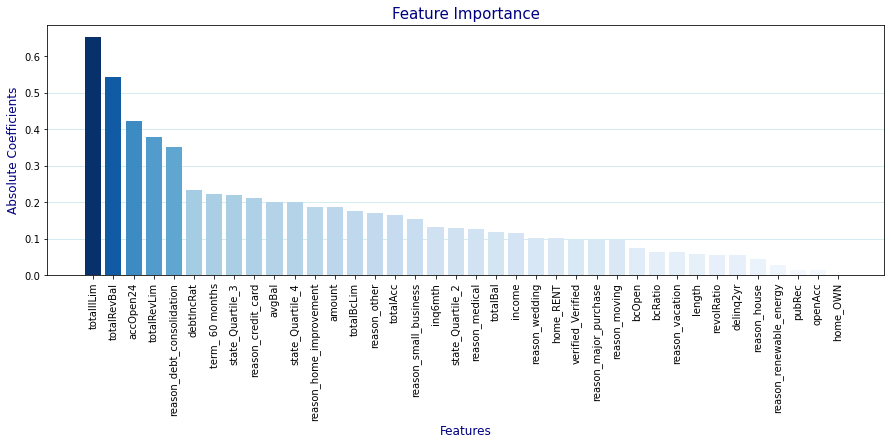

In [131]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('Blues')

# Get the absolute coefficients and feature names
coefs = np.abs(lr.coef_[0])
features = list(X_train.columns)

# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_coefs = coefs[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# Plot the feature importance with a color gradient
plt.figure(figsize=(15, 6))
bars = plt.bar(sorted_features, sorted_coefs, color=color_map(sorted_coefs / max(sorted_coefs)))
plt.xticks(rotation=90)
plt.xlabel('Features', size=12, color='navy')
plt.ylabel('Absolute Coefficients', size=12, color='navy')
plt.title('Feature Importance', size=15, color='navy')

# Add horizontal lines behind the bars.
for i in range(1, 6):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

plt.show()


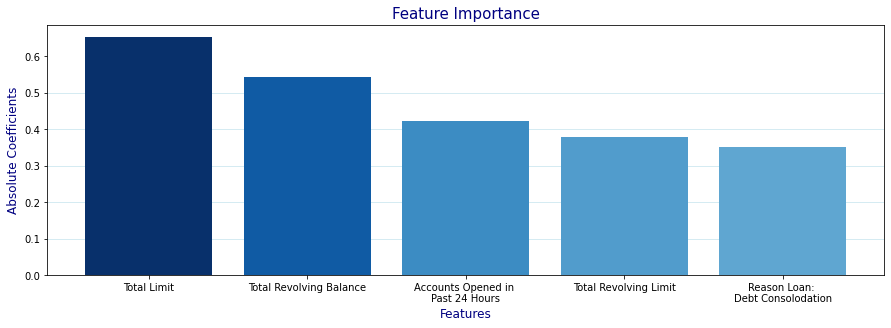

In [130]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('Blues')

# Get the absolute coefficients and feature names
coefs = np.abs(lr.coef_[0])
features = list(X_train.columns)

# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_coefs = coefs[sorted_idx][:5]
sorted_features = [features[i] for i in sorted_idx][:5]

# Plot the feature importance with a color gradient
plt.figure(figsize=(15, 6))
bars = plt.bar(sorted_features, sorted_coefs, color=color_map(sorted_coefs / max(sorted_coefs)))
plt.xticks(range(len(sorted_features)), ['Total Limit', 'Total Revolving Balance',\
                                         'Accounts Opened in \nPast 24 Hours', 'Total Revolving Limit',\
                                         'Reason Loan: \nDebt Consolodation'])
plt.xlabel('Features', size=12, color='navy')
plt.ylabel('Absolute Coefficients', size=12, color='navy')
plt.title('Feature Importance', size=15, color='navy')

# Add horizontal lines behind the bars.
for i in range(1, 6):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

plt.show()

In [90]:
# Sort the coefficients in descending order
sorted_idx = coefs.argsort()[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_coefs = coefs[sorted_idx]

# Create a DataFrame with the sorted features and coefficients
df_feature_importance = pd.DataFrame({'Feature': sorted_features, 'Coefficient': sorted_coefs})

# Print the DataFrame with the feature importance
df_feature_importance

,Feature,Coefficient
0,totalIlLim,0.653503
1,totalRevBal,0.544052
2,accOpen24,0.423631
3,totalRevLim,0.377999
4,reason_debt_consolidation,0.352019
5,debtIncRat,0.232986
6,term_ 60 months,0.221573
7,state_Quartile_3,0.219992
8,reason_credit_card,0.212426
9,avgBal,0.200047


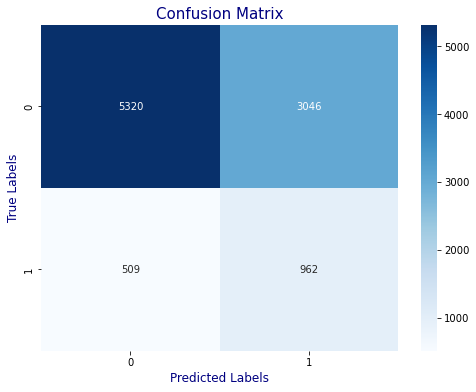

In [134]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels', size=12, color='navy')
plt.ylabel('True Labels', size=12, color='navy')
plt.title('Confusion Matrix', size=15, color='navy')
plt.show()